# Processing data

## Loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
df_orig = pd.read_csv("dataset_knn.csv")

In [3]:
df_orig.head()

,Отметка времени,пол,возраст,кто ты?,во сколько встаете?,далеко ли живешь от института?,особенности характера,работаете?,доход,был на паре 07.08
0,09.09.2023 15:23:00,ж,22,сова,8.00,да,интроверт,да,доволен,да
1,09.09.2023 15:25:11,м,21,сова,9:00,Нет,интроверт,да,недоволен,Нет
2,09.09.2023 15:25:43,м,22,сова,10,да,интроверт,Нет,недоволен,да
3,09.09.2023 15:26:02,м,22,сова,Время когда лягу + 7 часов сна,да,экстраверт,да,доволен,Нет
4,09.09.2023 15:27:41,ж,21,сова,11,да,интроверт,да,доволен,да


## Preprocessing data

In [4]:
df_0 = df_orig.rename(columns={
    "Отметка времени": "datetime",
    "пол": "sex",
    "возраст": "age",
    "кто ты?": "lark_owl",
    "во сколько встаете?": "wakeup",
    "далеко ли живешь от института?": "far",
    "особенности характера": "temperament",
    "работаете?": "is_work",
    "доход": "incoming",
    "был на паре 07.08": "attendance_07_09",
})

In [5]:
df_1 = df_0.copy()
df_1["datetime"] = pd.to_datetime(df_1["datetime"])
df_1["sex"] = df_1["sex"] == "м"
df_1["lark_owl"] = df_1["lark_owl"] == "сова"
df_1["wakeup"] = df_1["wakeup"]
df_1["far"] = df_1["far"].str.strip().str.lower() == "да"
df_1["temperament"] = df_1["temperament"] == "интроверт"
df_1["is_work"] = df_1["is_work"].str.strip().str.lower() == "да"
df_1["incoming"] = df_1["incoming"] == "доволен"
df_1["attendance_07_09"] = df_1["attendance_07_09"].str.strip().str.lower() == "да"

def get_time_wakeup(obj: str):
    try:
        return int(obj) * 60
    except ValueError:
        pass
    obj = obj.replace(".", ":")
    try:
        h, m = map(int, obj.strip().split(":"))
    except ValueError:
        pass
    else:
        return h * 60 + m
    return float("nan")

df_1["wakeup"] = df_1["wakeup"].map(get_time_wakeup)

In [6]:
df_2 = df_1.dropna()

In [7]:
df_2.sample(5, random_state=44)

,datetime,sex,age,lark_owl,wakeup,far,temperament,is_work,incoming,attendance_07_09
9,2023-09-09 20:04:24,True,21,False,450.0,True,False,True,False,False
8,2023-09-09 19:30:08,True,22,True,660.0,True,True,True,True,False
2,2023-09-09 15:25:43,True,22,True,600.0,True,True,False,False,True
11,2023-10-09 18:24:26,True,22,False,360.0,False,True,True,True,False
0,2023-09-09 15:23:00,False,22,True,480.0,True,True,True,True,True


In [8]:
X = df_2.drop(["attendance_07_09", "datetime"], axis=1)
y = df_2["attendance_07_09"]

## Some plots

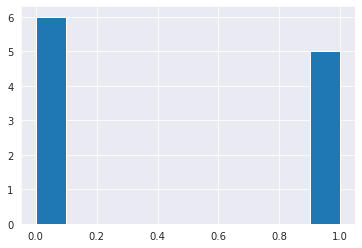

In [9]:
df_2["attendance_07_09"].astype(int).hist();

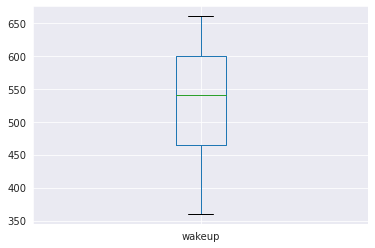

In [10]:
df_2.boxplot(column=["wakeup"]);

### t-SNE plot

In [11]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate="auto", perplexity=3, init="random", random_state=12).fit_transform(X)
X_embedded.shape

(11, 2)

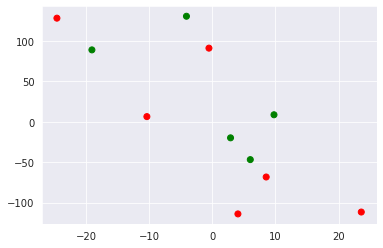

In [12]:
colors = np.array(["r", "g", "b"])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors[y.astype(int)])
plt.show()

# KNN

## Realization of KNN

In [13]:
from collections import Counter


class CustomKNNClassifier:
    def __init__(self, n_neighbors: int = 5, *, p: int = 2) -> None:
        self._X_ = None
        self._y_ = None
        
        self.n = n_neighbors
        self._p = p
            
    def fit(self, X, y):
        self._X_ = X.copy()
        self._y_ = y.copy()
        return self
        
    def predict(self, X):
        assert X.shape[1:] == self._X_.shape[1:]
        return np.apply_along_axis(self._get_label_for_row, 1, X)

    def _get_label_for_row(self, row):
        dists = self._minkowski_dist(self._X_, row, self._p)
        dists_with_labels = np.column_stack((self._y_, dists))
        sorted_dists_with_labels = dists_with_labels[dists_with_labels[:, 1].argsort()]
        count_labels = Counter(sorted_dists_with_labels[0 : self.n, 0])
        return count_labels.most_common(1)[0][0]

    @staticmethod
    def _minkowski_dist(x1, x2, p):
        return np.sum(np.abs(x1-x2) ** p, axis=1) ** (1/p)

## Learning model

### Split data to train/test datasets

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=40)

In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8, 8), (8,), (3, 8), (3,))

### Actually training model

In [16]:
clf = CustomKNNClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

### Estimating model accuracy

In [17]:
from sklearn.metrics import accuracy_score

y_val_pred = clf.predict(X_val)
accuracy_score(y_val, y_val_pred)

0.6666666666666666

### Save model to file

In [18]:
import pickle
with open("knn_custom_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)

### Read model from file

In [19]:
# import pickle
# with open("knn_custom_classifier.pkl", "rb") as f:
#     clf = pickle.load(f)